In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = '/content/drive/My Drive/Genomics_Project'  # rohan

In [2]:
directory = '/content/drive/My Drive/ML4Genomics/ML4FG Project/Data'  # sparsh

In [ ]:
directory = 'C:/Users/rarora9/Documents/Genomics/Project/Data'  # rohan gpu

# Load Data

In [3]:
"""
Parses the count file into usable dictionaries, for quick, easy data access

headers is a dict, mapping assay index (column number) to name of assay
assay_map is a dict, mapping name of assay to a list of all gene expressions across all genes for that assay
gene_map is a dict, mapping name of gene to a list of all gene expressions across all assays for that gene
gene_idx_lookup is a dict, mapping the name of the gene to that specific gene's index (row number)

Author: Sparsh Srivastava - ss6381, Rohan Arora - ra3091
"""
headers = {}
assay_map = {}
gene_map = {}
gene_idx_lookup = {}


def get_mappings():
    """
    opens the file, parses the data, and populates the global assay_map and global gene_map
    into in-memory data structures, to allow for easy O(1) access
    """
    with open(directory + '/pancreas_refseq_rpkms_counts_3514sc.txt', 'r') as file:
        isHeader = True
        gene_idx = 0
        for line in file:
            if isHeader:
                get_headers(line)  # populates headers dict
                isHeader = False
            else:
                parse_line_into_mappings(line, gene_idx)  # populates assay_map and gene_map dicts
                gene_idx += 1
        return assay_map, gene_map


def get_headers(line):
    """
    retrieves the first line of the data file, which contains all of the headers / assay names
    and associates those names with their assay_idx, which is the index of one specific column of data
    """
    assay_idx = 0  # column number
    for assay_name in line.split()[1:]:  # skip #samples
        headers[assay_idx] = assay_name
        assay_map[assay_name] = []
        assay_idx += 1


def parse_line_into_mappings(line, gene_idx):
    """
    parses the single line from data file (string) into the global assay_map and global gene_map

    gene_expressions is a list of gene expressions for a specific gene
    """
    gene_expressions = []
    assay_idx = 0  # column number / gene expression index
    # skip gene name and accession number
    for gene_expr in line.split()[2:]:
        if assay_idx < len(headers):
            # assay mapping, assuming unique assays with no duplicates
            curr_assay_name = headers.get(assay_idx)
            assay_map[curr_assay_name].append(gene_expr)

            # store gene expressions for gene mapping
            gene_expressions.append(gene_expr)
        assay_idx += 1
    # gene mapping
    gene_name = line.split()[0]
    if gene_name in gene_idx_lookup:
        gene_idx_lookup[gene_name].append(gene_idx)
    else:
        gene_idx_lookup[gene_name] = [gene_idx]
    gene_map[gene_idx] = gene_expressions


def get_gene_expressions_list(gene_name):
    """
    retrieves the gene expression data for a given gene name

    gene expressions list is created for the scenario of duplicate genes in the data,
    in order to create a list of lists of gene expression values
    """
    gene_expressions_list = []
    for gene_idx in gene_idx_lookup[gene_name]:  # gene_idx is the row number
        gene_expressions_list.append(gene_map[gene_idx])
    return gene_expressions_list


def get_gene_expression_value_by_index(assay_index, gene_index):
    """
    retrieves the gene expression value using the assay index and gene index (column number x row number)
    """
    assay_name = headers[assay_index]
    return assay_map[assay_name][gene_index]


def get_gene_expression_value_by_name(assay_name, gene_name):
    """
    retrieves the gene expression value(s) using the assay name and gene name
    since there can be duplicate gene names, this function returns a list of values
    """
    gene_expr_vals = []
    gene_indices = gene_idx_lookup[gene_name]
    for idx in gene_indices:
        gene_expr_vals.append(assay_map[assay_name][idx])
    return gene_expr_vals

In [4]:
# function call
assay_map, gene_map = get_mappings()

In [5]:
# data format validation
print(f"length of assay map: {len(assay_map)}")  # length of assay_map
print(f"length of gene map: {len(gene_map)}")  # length of gene_map

assay_name = 'HP1502401_D14'
# length of specific assay
print(f"length of {assay_name} assay: {len(assay_map[assay_name])}")

gene_name = 'DUX4L4'
num_gene_count = 0
for gene_expressions in get_gene_expressions_list(gene_name):
    # length of specific gene
    print(f"{num_gene_count} - length of {gene_name} gene: {len(gene_expressions)}")
    num_gene_count += 1

assay_idx = 4
gene_idx = 24102  # PTOV1, subtract 2 from row number
print(
    f"gene expression value for assay index {assay_idx} and gene index {gene_idx}: {get_gene_expression_value_by_index(assay_idx, gene_idx)}")

assay_name = 'HP1502401_B13'
gene_name = 'PTOV1'
print(
    f"gene expression value for assay name {assay_name} and gene name {gene_name}: {get_gene_expression_value_by_name(assay_name, gene_name)}")

# print(f"gene map: {gene_map}")
# gene_name = 'SGIP1'
# num_gene_count = 0
# for gene_expressions in get_gene_expressions_list(gene_name):
#     print(f"{num_gene_count} - {gene_name} gene: {gene_expressions}")
#     num_gene_count += 1

length of assay map: 3514
length of gene map: 26271
length of HP1502401_D14 assay: 26271
0 - length of DUX4L4 gene: 3514
1 - length of DUX4L4 gene: 3514
2 - length of DUX4L4 gene: 3514
3 - length of DUX4L4 gene: 3514
gene expression value for assay index 4 and gene index 24102: 92.6620798933
gene expression value for assay name HP1502401_B13 and gene name PTOV1: ['92.6620798933']


In [ ]:
print(headers)

In [ ]:
print(assay_map['HP1502401_D14'])

In [ ]:
print(len(get_gene_expressions_list('TMEM51')[0]))

In [6]:
'''
Code for obtaining information about each assay (quality, cell type, disease state).
Includes functions to retrieve assay names of specific types.
'''

import re


all_assays = set()

assay_individual = {}
all_individuals = set()

assay_quality = {}
all_qualities = set()

assay_cell_type = {}
all_cell_types = set()

assay_disease_state = {}
all_disease_states = set()


def get_assay_info(): # Make sure to call this function first
    is_header = True
    
    with open(directory + '/E-MTAB-5061.sdrf.txt', 'r') as file:
        for line in file:
            if is_header == True:
                is_header = False
                continue
            
            info = re.split(r'\t+', line.rstrip('\t'))
            assay_name = info[0]
            individual = info[5]
            quality = info[6]
            cell_type = info[7]
            disease_state = info[8]
            
            if assay_name in all_assays:
                raise Exception('Duplicate assay found!')
            
            all_assays.add(assay_name)
            
            assay_individual[assay_name] = individual
            all_individuals.add(individual)
            
            assay_quality[assay_name] = quality
            all_qualities.add(quality)
            
            assay_cell_type[assay_name] = cell_type
            all_cell_types.add(cell_type)
            
            assay_disease_state[assay_name] = disease_state
            all_disease_states.add(disease_state)


def get_all_assays() -> list:
    return list(all_assays)


def get_assays_from_individuals(assays: list, individuals: list) -> list:
    result = list()
    
    for assay in assays:
        if assay_individual[assay] in individuals:
            result.append(assay)
    
    return result


def get_assays_from_qualities(assays: list, qualities: list) -> list:
    result = list()
    
    for assay in assays:
        if assay_quality[assay] in qualities:
            result.append(assay)
    
    return result


def get_assays_from_cell_types(assays: list, cell_types: list) -> list:
    result = list()
    
    for assay in assays:
        if assay_cell_type[assay] in cell_types:
            result.append(assay)
    
    return result

def get_assays_from_disease_states(assays: list, disease_states: list) -> list:
    result = list()
    
    for assay in assays:
        if assay_disease_state[assay] in disease_states:
            result.append(assay)
    
    return result


get_assay_info()

In [7]:
print(f"individuals: {all_individuals}\n")
print(f"qualities: {all_qualities}\n")
print(f"cell_types: {all_cell_types}\n")
print(f"disease_states: {all_disease_states}\n")

individuals: {'HP1502401', 'HP1504101T2D', 'HP1504901', 'HP1507101', 'HP1525301T2D', 'HP1506401', 'HP1526901T2D', 'HP1508501T2D', 'HP1509101', 'AZ'}

qualities: {'control, empty well', 'OK', 'control, 2-cell well', 'low quality cell'}

cell_types: {'ductal cell', 'unclassified cell', 'alpha cell', 'MHC class II cell', 'co-expression cell', 'unclassified endocrine cell', 'PSC cell', 'endothelial cell', 'mast cell', 'not applicable', 'acinar cell', 'delta cell', 'epsilon cell', 'beta cell', 'gamma cell'}

disease_states: {'normal', 'type II diabetes mellitus'}



In [8]:
print(f"assay HP1525301T2D_B10 individual: {assay_individual['HP1525301T2D_B10']}\n")
print(f"assay HP1525301T2D_B10 quality: {assay_quality['HP1525301T2D_B10']}\n")
print(f"assay HP1525301T2D_B10 cell type: {assay_cell_type['HP1525301T2D_B10']}\n")
print(f"assay HP1525301T2D_B10 disease state: {assay_disease_state['HP1525301T2D_B10']}\n")

assay HP1525301T2D_B10 individual: HP1525301T2D

assay HP1525301T2D_B10 quality: OK

assay HP1525301T2D_B10 cell type: ductal cell

assay HP1525301T2D_B10 disease state: type II diabetes mellitus



In [9]:
assays_of_interest = get_all_assays()
assays_of_interest = get_assays_from_individuals(assays_of_interest, ['HP1508501T2D', 'HP1507101'])
assays_of_interest = get_assays_from_qualities(assays_of_interest, ['OK'])
assays_of_interest = get_assays_from_cell_types(assays_of_interest, ['gamma cell', 'ductal cell', 'beta cell'])
assays_of_interest = get_assays_from_disease_states(assays_of_interest, ['type II diabetes mellitus'])

print(assays_of_interest)

['HP1508501T2D_N1', 'HP1508501T2D_G13', 'HP1508501T2D_A10', 'HP1508501T2D_B18', 'HP1508501T2D_N2', 'HP1508501T2D_C18', 'HP1508501T2D_M23', 'HP1508501T2D_N7', 'HP1508501T2D_H14', 'HP1508501T2D_N23', 'HP1508501T2D_B20', 'HP1508501T2D_H13', 'HP1508501T2D_B17', 'HP1508501T2D_O4', 'HP1508501T2D_G14', 'HP1508501T2D_O8', 'HP1508501T2D_I4', 'HP1508501T2D_E17', 'HP1508501T2D_K3', 'HP1508501T2D_E11', 'HP1508501T2D_K22', 'HP1508501T2D_L23', 'HP1508501T2D_O9', 'HP1508501T2D_M3', 'HP1508501T2D_A7', 'HP1508501T2D_N19', 'HP1508501T2D_C15', 'HP1508501T2D_J22', 'HP1508501T2D_G22', 'HP1508501T2D_O3', 'HP1508501T2D_F4', 'HP1508501T2D_G1', 'HP1508501T2D_N18', 'HP1508501T2D_C11', 'HP1508501T2D_C4', 'HP1508501T2D_E7', 'HP1508501T2D_K15', 'HP1508501T2D_E15', 'HP1508501T2D_I12', 'HP1508501T2D_B16', 'HP1508501T2D_F5', 'HP1508501T2D_N6', 'HP1508501T2D_O12', 'HP1508501T2D_N15', 'HP1508501T2D_J14', 'HP1508501T2D_L11', 'HP1508501T2D_M14', 'HP1508501T2D_J13', 'HP1508501T2D_N17', 'HP1508501T2D_I8', 'HP1508501T2D_L5'

In [10]:
'''
Function for determining which individuals to include in the training set.
'''

import math
import random


def get_train_individuals(train_ratio: float):
    num_train = math.floor(train_ratio * len(all_individuals))
    train_individuals = random.sample(list(all_individuals), num_train)

    print(f"The training set includes (individuals): {train_individuals}")
    return train_individuals


def get_test_individuals():
    test_individuals = ['HP1525301T2D', 'HP1509101']
    return test_individuals

In [11]:
'''
Function for creating the training and test set split of assays
with 15 fold cross validation
'''

NORMAL = 'normal'


def is_normal(individual):
    assay = get_assays_from_individuals(get_all_assays(), individual)[0]
    return assay_disease_state[assay] == NORMAL


def get_train_val_test_split(test_individuals: list, quals: list, cells: list) -> (list, list):
    if len(test_individuals) != 2:
        print("Invalid input for test individuals, should be length 2")
        return

    individual_1_normal = is_normal(test_individuals[0])
    individual_2_normal = is_normal(test_individuals[1])

    if individual_1_normal and individual_2_normal:
        print("Invalid test individuals, both normal")
        return
    
    if not individual_1_normal and not individual_2_normal:
        print("Invalid test individuals, both not normal")
        return
    
    assays_of_interest = get_all_assays()
    assays_of_interest = get_assays_from_qualities(assays_of_interest, quals)
    assays_of_interest = get_assays_from_cell_types(assays_of_interest, cells)

    test_assays = get_assays_from_individuals(assays_of_interest, test_individuals)
    random.shuffle(test_assays)

    test_individuals = set(test_individuals)
    train_val_individuals = all_individuals.difference(test_individuals)

    train_val_normal = list()
    train_val_t2d = list()
    for ind in train_val_individuals:
        if is_normal(ind):
            train_val_normal.append(ind)
        else:
            train_val_t2d.append(ind)


    val_individuals = list()
    train_individuals = list()

    val_assays = list()
    train_assays = list()

    for ind_normal in train_val_normal:
        for ind_t2d in train_val_t2d:
            curr_val_inds = list()
            curr_train_inds = list()
            for ind in train_val_individuals:
                if ind == ind_normal or ind == ind_t2d:
                    curr_val_inds.append(ind)
                else:
                    curr_train_inds.append(ind)
            
            curr_val_assays = get_assays_from_individuals(assays_of_interest, curr_val_inds)
            random.shuffle(curr_val_assays)
            val_assays.append(curr_val_assays)

            curr_train_assays = get_assays_from_individuals(assays_of_interest, curr_train_inds)
            random.shuffle(curr_train_assays)
            train_assays.append(curr_train_assays)

            val_individuals.append(curr_val_inds)
            train_individuals.append(curr_train_inds)
                
    return train_assays, val_assays, test_assays, train_individuals, val_individuals

In [ ]:
test_individuals = get_test_individuals()
train_assays, val_assays, test_assays, train_inds, val_inds = get_train_val_test_split(test_individuals, ['OK'], ['alpha cell'])

print("\n\n")
print("Train assays:\n\n")
print(train_assays)

print("\n\n")
print("Val assays:\n\n")
print(val_assays)

print("\n\n")
print("Test assays:\n\n")
print(test_assays)

print(len(train_assays) + len(test_assays))




Train assays:


[['HP1504101T2D_N17', 'HP1504101T2D_O9', 'HP1504901_I12', 'HP1502401_M10', 'HP1504901_C11', 'HP1504101T2D_P7', 'HP1502401_I4', 'HP1504101T2D_N13', 'HP1504901_F24', 'HP1504101T2D_O10', 'HP1504101T2D_N12', 'HP1504101T2D_C4', 'HP1504101T2D_C20', 'HP1526901T2D_L21', 'HP1504101T2D_A23', 'HP1504901_B16', 'AZ_A6', 'HP1504101T2D_I22', 'HP1526901T2D_A12', 'HP1526901T2D_L11', 'HP1504101T2D_P18', 'HP1526901T2D_D8', 'HP1506401_N4', 'HP1504101T2D_K18', 'HP1504101T2D_F22', 'AZ_A11', 'HP1502401_J20', 'HP1504901_N19', 'HP1526901T2D_D16', 'HP1504101T2D_I2', 'HP1504901_F5', 'HP1504101T2D_L10', 'HP1502401_E6', 'HP1504901_M12', 'HP1502401_F20', 'HP1502401_G7', 'HP1526901T2D_B12', 'HP1526901T2D_N8', 'HP1504101T2D_M7', 'HP1526901T2D_M7', 'HP1502401_J1', 'HP1502401_N15', 'HP1504901_J6', 'HP1502401_L15', 'HP1502401_A15', 'HP1504101T2D_C14', 'HP1526901T2D_M21', 'HP1504901_B21', 'HP1504101T2D_M18', 'HP1502401_F12', 'HP1502401_E11', 'HP1504101T2D_N24', 'HP1504101T2D_B11', 'HP1526901T2D_A3', 'H

In [ ]:
'''
Function for creating torch tensors for the inputs and labels needed for training.
'''

import torch

def get_inputs_labels_from_assays(assays: list) -> (torch.Tensor, torch.Tensor):
    inputs = list()
    labels = list()

    for assay in assays:
        inputs.append([float(x) for x in assay_map[assay]])

        if assay_disease_state[assay] == NORMAL:
            labels.append(0) # normal
        else:
            labels.append(1) # type II diabetes mellitus
    
    inputs_tensor = torch.FloatTensor(inputs)
    labels_tensor = torch.LongTensor(labels)

    return (inputs_tensor, labels_tensor)

In [ ]:
inputs_tensor, labels_tensor = get_inputs_labels_from_assays(test_assays)

'''Uncomment code below to show tensors.'''
print("Inputs:\n\n")
print(inputs_tensor)
print("\n\n")
print("Labels:\n\n")
print(labels_tensor)

Inputs:


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 5.3720, 8.9218,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])



Labels:


tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1])


# Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
# from torchvision import transforms

In [ ]:
# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class T2DDataSet(Dataset):
    def __init__(self, X, Y, train=True):
        self.X = X
        self.Y = Y
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        _x = self.X[index]
        _y = self.Y[index]

        return _x, _y

In [ ]:
# Neural network class
class T2D_NN(nn.Module):
    def __init__(self, num_inputs, num_outputs, width, depth):
        super(T2D_NN, self).__init__()
        # self.final_max_pool = self.get_final_pool_layer()
        self.fc_model = self.get_fc_layers(num_inputs, num_outputs, width, depth)

    def forward(self, x):
        # x = self.final_max_pool(x)
        # x = x.reshape(x.shape[0], -1)
        x = self.fc_model(x)
        return x

    # def get_final_pool_layer(self):
    #     layer = nn.MaxPool2d(kernel_size=2, stride=2)
    #     return layer

    def get_fc_layers(self, num_inputs, num_outputs, width, depth):
        layers = None
        if depth == 2:
            layers = nn.Sequential(
                nn.Linear(num_inputs, width),
                nn.ReLU(),
                nn.Linear(width, num_outputs)
            )
        elif depth == 3:
            layers = nn.Sequential(
                nn.Linear(num_inputs, width),
                nn.ReLU(),
                nn.Linear(width, int(width/2)),
                nn.ReLU(),
                nn.Linear(int(width/2), num_outputs)
            )
        elif depth == 4:
            layers = nn.Sequential(
                nn.Linear(num_inputs, width),
                nn.ReLU(),
                nn.Linear(width, int(width/2)),
                nn.ReLU(),
                nn.Linear(int(width/2), int(width/4)),
                nn.ReLU(),
                nn.Linear(int(width/4), num_outputs)
            )
        return layers
    

In [ ]:
# Classifier class
class Classifier():
    def __init__(self, model, dataloaders, criterion, optimizer, use_cuda=False, learning_rate=0.001):

        self.model = model
        self.dataloaders = dataloaders

        # Loss and optimizers
        self.criterion = criterion
        self.optimizer = optimizer
        print(self.optimizer.state_dict()['state'])


    # Train network
    def train(self, num_epochs=5, patience=10):
        train_losses = []
        val_losses = []
        accuracies = []

        epoch_loss = 0.0
        patience_counter = patience
        best_val_loss = np.inf

        for epoch in range(num_epochs):
            print(f"Epoch {epoch} -")

            self.model.train()

            batches_in_pass = len(self.dataloaders['train'])
            
            for batch_idx, (data, labels) in enumerate(self.dataloaders['train']):
                data = data.to(device=device)
                labels = labels.to(device=device)

                # forward
                scores = model(data)
                loss = self.criterion(scores, labels)

                # backward
                self.optimizer.zero_grad()
                loss.backward()

                # gradient descent
                self.optimizer.step()

                epoch_loss += loss.item()

            epoch_loss /= batches_in_pass
            print(f'Train Epoch Loss (Avg): {epoch_loss}, patience: {patience_counter}')
            acc, val_loss = self.evaluate(self.dataloaders['val'])

            if val_loss < best_val_loss: 
                best_val_loss = val_loss
                patience_counter = patience
            else:
                patience_counter -= 1
                if patience_counter <= 0: 
                    break

            train_losses.append(epoch_loss)
            val_losses.append(val_loss)
            accuracies.append(acc)
        
        print('Done training!')
        plt.plot(train_losses, label='Training Loss')
        plt.plot(accuracies, label='Validation Accuracy')
        plt.legend()
        plt.show()

        return best_val_loss


    # Check accuracy
    def evaluate(self, loader):
        if loader.dataset.train:
            print("Checking accuracy on validation data")
        else:
            print("Checking accuracy on test data")

        num_correct = 0
        num_samples = 0
        total_loss = 0

        self.model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=device)
                y = y.to(device=device)

                scores = self.model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y).sum()
                num_samples += predictions.size(0)

                loss = self.criterion(scores, y)
                total_loss += loss.item()

            total_loss /= len(loader)
            acc = (float(num_correct) / float(num_samples)) * 100
            print(f"Got {num_correct} / {num_samples} with accuracy {acc} and loss {total_loss}")
        
        return acc, total_loss

In [ ]:
def get_loaders(train_assays, val_assays, test_assays, batch_size=1):
    x_train, y_train = get_inputs_labels_from_assays(train_assays)
    train_loader = DataLoader(
        dataset=T2DDataSet(x_train, y_train, train=True),
        batch_size=batch_size,
        shuffle=True
    )
    x_val, y_val = get_inputs_labels_from_assays(val_assays)
    val_loader = DataLoader(
        dataset=T2DDataSet(x_val, y_val, train=True),
        batch_size=batch_size,
        shuffle=True
    )
    x_test, y_test = get_inputs_labels_from_assays(test_assays)
    test_loader = DataLoader(
        dataset=T2DDataSet(x_test, y_test, train=False),
        batch_size=batch_size, 
        shuffle=True
    )
    return train_loader, val_loader, test_loader

# Cross Validation

In [ ]:
# Hyperparameters
batch_size = 1
input_size = 26271
output_size = 2

width = 8192  # (must be power of 2)
depth = 3  # (must be either 2, 3, or 4)
patience = 10 # for early stopping
learning_rate = 0.00000001
num_epochs = 20
cell_types = [['alpha cell'], ['beta cell'], ['gamma cell']]

"""
widths = [1024, 2048, 4096, 8192]  # (must be power of 2)
depths = [2, 3, 4]  # (must be either 2, 3, or 4)
momentum = 0
patience = 10 # for early stopping
learning_rates = [0.00001, 0.000001, 0.0000001]
num_epochs = 100
"""

# Load data
test_individuals = get_test_individuals()
train_assays_list, val_assays_list, test_assays, train_inds, val_inds = get_train_val_test_split(test_individuals, ['OK'], cell_types[0])

print(len(train_assays_list))

# Cross validation
total_val_loss = 0

for idx in range(len(train_assays_list)):
    print(f"cross val iteration: {idx}")
    print("train inds:")
    print(train_inds[idx])
    print("val inds:")
    print(val_inds[idx])
    train_assays = train_assays_list[idx]
    val_assays = val_assays_list[idx]

    # Data loaders
    train_loader, val_loader, test_loader = get_loaders(train_assays, val_assays, test_assays, batch_size)
    dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

    # Initialize neural network
    model = T2D_NN(num_inputs=input_size, num_outputs=output_size, width=width, depth=depth).to(device=device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    classifier = Classifier(model, dataloaders, criterion, optimizer)
    val_loss = classifier.train(num_epochs, patience)
    total_val_loss += val_loss
    print(f"Total validation loss: {total_val_loss}")
    test_acc, test_loss = classifier.evaluate(classifier.dataloaders['test'])
    print(f"test accuracy: {test_acc}, test loss: {test_loss}")

total_val_loss /= len(train_assays_list)
print(f"Average cross validation loss: {total_val_loss}")

In [ ]:
# torch.save(model.state_dict(), directory + "/goodaf.pt")

In [ ]:
input_size = 26271
output_size = 2
width = 8192
depth = 3

model = T2D_NN(num_inputs=input_size, num_outputs=output_size, width=width, depth=depth).to(device=device)
model.load_state_dict(torch.load(directory + 'goodaf.pt'))

<All keys matched successfully>

# In Silico

In [ ]:
#IMPROVED IN SILICO
import math

EXP_MIN_VAL = 0.
delta_output = torch.zeros((1, 26271), device=device)
total_examples = 0

torch.set_grad_enabled(False)
for (x_cpu,y_cpu) in dataloaders['test']:
    x = x_cpu.to(device)
    y = y_cpu.to(device)
    output = model(x).squeeze()
    print(output)
    #output = torch.sigmoid(output)
    if output[0] > output[1]:
        continue
    
    total_examples += 1
    # delta_output = torch.zeros((1, x.shape[1]), device=device)

    for seq_idx in range(x.shape[1]): # iterate over sequence
        x_prime = x.clone()
        x_prime[0, seq_idx] = EXP_MIN_VAL
        output_prime = model(x_prime).squeeze()
        #output_prime = torch.sigmoid(output_prime)
        output_diff = output[1] - output[0]
        output_prime_diff = output_prime[1] - output_prime[0]
        diff = output_diff - output_prime_diff
        if diff < 0:
            diff = torch.tensor(0., device=device)
        delta_output[0, seq_idx] += diff

delta_output = torch.div(delta_output, total_examples)
delta_output = torch.tanh(delta_output)

# torch.save(delta_output, directory + "/delta")

tensor([-3.0386,  0.9712], device='cuda:0')
tensor([-8.1568, 16.8025], device='cuda:0')
tensor([14.5009, -3.3729], device='cuda:0')
tensor([10.0913,  5.1351], device='cuda:0')
tensor([-5.5244,  0.7023], device='cuda:0')
tensor([3.7801, 7.5700], device='cuda:0')
tensor([-4.2980, 11.3335], device='cuda:0')
tensor([ 3.0519, -7.1463], device='cuda:0')
tensor([-0.1448,  2.9557], device='cuda:0')
tensor([  1.1154, -17.9829], device='cuda:0')
tensor([ 1.8999, -4.2728], device='cuda:0')
tensor([0.5473, 2.9368], device='cuda:0')
tensor([-1.5430,  6.2471], device='cuda:0')
tensor([12.7837,  3.6566], device='cuda:0')
tensor([-1.2684,  9.8663], device='cuda:0')
tensor([21.1924,  7.1781], device='cuda:0')
tensor([ 4.9589, 10.8252], device='cuda:0')
tensor([-6.0244, -0.4040], device='cuda:0')
tensor([6.0661e+00, 5.6262e-03], device='cuda:0')
tensor([3.7056, 8.4926], device='cuda:0')
tensor([1.7813, 3.0921], device='cuda:0')
tensor([-7.1232, -8.9412], device='cuda:0')
tensor([2.2839, 5.4975], device=

[1.]
[0.]
[3848]
[0]


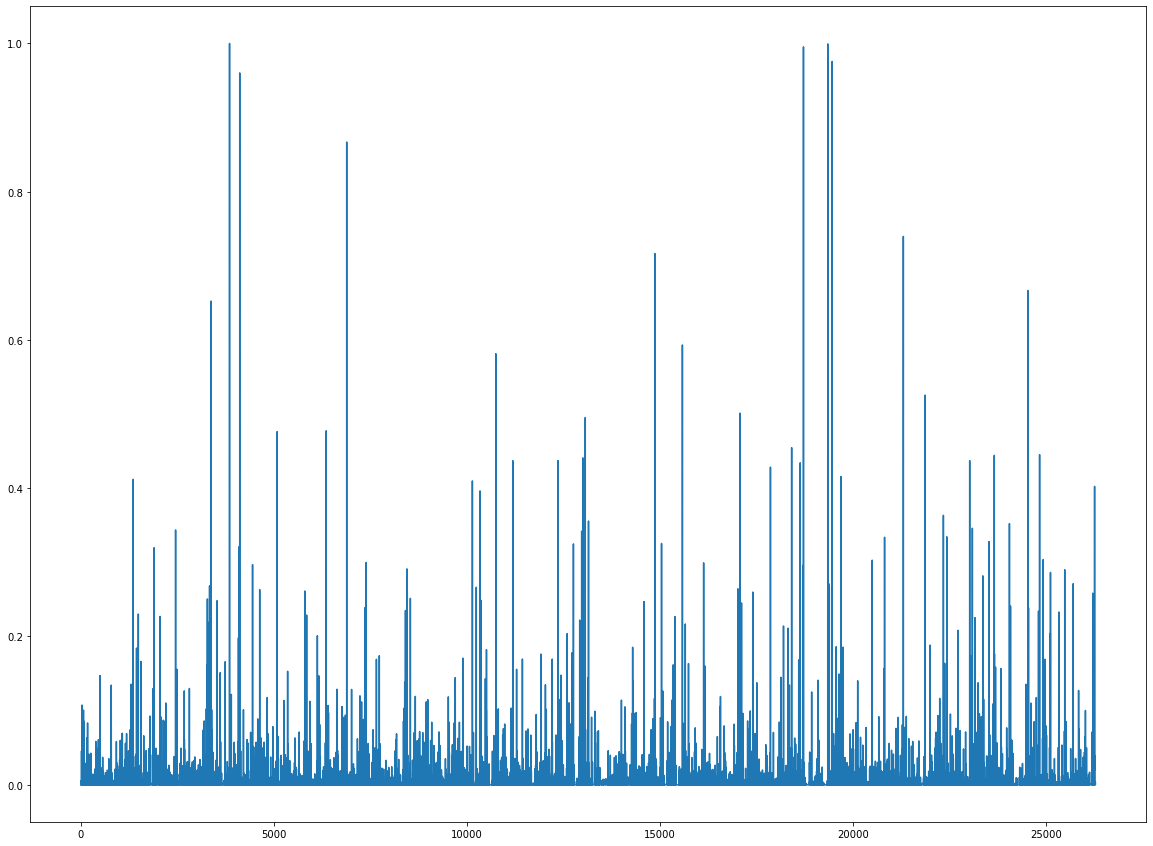

In [ ]:
import pandas as pd

delta_output_np = delta_output.detach().cpu().numpy()

print(np.max(delta_output_np, axis=1))
print(np.min(delta_output_np, axis=1))

# delta_output_np -= delta_output_np.mean(1, keepdims=True)
print(np.argmax(delta_output_np, axis=1))
print(np.argmin(delta_output_np, axis=1))
delta_output_np = delta_output_np[:,:]

plt.figure(figsize = (20,15))

delta_output_np = delta_output_np.tolist()[0]
plt.plot(delta_output_np, label='')
# plt.legend()
plt.show()

##Most Impactful Genes

In [ ]:
# most impactful genes
expr_idx_list = list()

for idx in range(len(delta_output_np)):
    expr_idx_list.append((delta_output_np[idx], idx))

expr_idx_list.sort(reverse=True)

print(expr_idx_list[0:10])

[(1.0, 3848), (0.9993889331817627, 19338), (0.9953703284263611, 18709), (0.97581547498703, 19453), (0.9602512121200562, 4112), (0.8670117855072021, 6882), (0.7397007346153259, 21295), (0.7166571617126465, 14861), (0.6666936874389648, 24518), (0.6524530053138733, 3370)]


In [ ]:
# ranking
idx_list = list()
num_genes = len(expr_idx_list)

for expr_idx in expr_idx_list:
    idx_list.append(expr_idx[1])

t2d_genes = [(21185, 'SGSM2'), (22409, 'BCL2'), (18918, 'RASGRP1'), (3864, 'G6PC2'), (5492, 'SLC2A2'), (10411, 'ZMAT4'), (4213, 'CAPN10'), (13942, 'TCF7L2')]

for t2d_gene in t2d_genes:
    ranking = idx_list.index(t2d_gene[0]) + 1
    print(f"t2d_gene: {t2d_gene[1]}, ranking: {ranking}, top {(ranking / num_genes) * 100.}%")

t2d_gene: SGSM2, ranking: 2136, top 8.130638346465686%
t2d_gene: BCL2, ranking: 14528, top 55.30052148757185%
t2d_gene: RASGRP1, ranking: 9904, top 37.69936431806936%
t2d_gene: G6PC2, ranking: 4231, top 16.105211069239846%
t2d_gene: SLC2A2, ranking: 23530, top 89.5664420844277%
t2d_gene: ZMAT4, ranking: 21059, top 80.16063339804347%
t2d_gene: CAPN10, ranking: 2845, top 10.829431692741046%
t2d_gene: TCF7L2, ranking: 6437, top 24.502302919569107%


# Logistic Regression

In [ ]:
'''
Function for creating torch tensors for the inputs and labels needed for training.
'''

def get_inputs_labels_from_assays_logistic_cuda(assays: list) -> (torch.Tensor, torch.Tensor):
    inputs = list()
    labels = list()
    
    for assay in assays:
        inputs.append([float(x) for x in assay_map[assay]])

        if assay_disease_state[assay] == NORMAL:
            labels.append(0) # normal
        else:
            labels.append(1) # type II diabetes mellitus
    
    inputs_tensor = torch.tensor(inputs, dtype=torch.float, device=device, requires_grad=False)
    inputs_tensor = torch.cat((inputs_tensor, torch.ones((inputs_tensor.shape[0], 1), device=device)), axis=1)
    labels_tensor = torch.tensor(labels, dtype=torch.float, device=device, requires_grad=False) 

    return (inputs_tensor, labels_tensor)

In [ ]:
def logistic_reg_loss_and_gradient(X, y, beta):
    beta.requires_grad = True # tell torch we will want gradients wrt to this
    if not beta.grad is None: beta.grad.zero_() # clear old gradient values from previous iterations
    g = X @ beta
    p = torch.sigmoid(g)
    loss = - torch.mean( y * torch.log(p) + (1.-y) * torch.log(1.-p) )
    loss.backward()
    beta.requires_grad = False # other it will try to track gradients during GD itself! 
    return(loss, beta.grad)

In [ ]:
# L2 learning_rate = 0.000000000005
# L1 learning_rate = 0.0000000000000005

def fit_logistic_reg(X, y, l1_lambda = 0., l2_lambda = 0., learning_rate = 0.000000000005, iterations = 100): 
    beta = torch.zeros(X.shape[1], device=device)
    y_mean = y.mean()
    beta[-1] = torch.log(y_mean) - torch.log(1. - y_mean) # intercept init
    losses = []
    for it in range(iterations):
        loss, grad = logistic_reg_loss_and_gradient(X, y, beta)
        beta_no_int = beta[:-1] # beta excluding the intercept term at the end
        loss += l1_lambda * beta_no_int.abs().sum() + .5 * l2_lambda * (beta_no_int*beta_no_int).sum()
        losses.append(loss.item())
        grad[:-1] += l1_lambda * torch.sign(beta_no_int) + l2_lambda * beta_no_int # don't regularize intercept term
        if np.isnan(loss.item()): 
            print("Warning: GD diverged at iteration %i" % it)
            return(beta * np.nan, losses) # return nan beta if diverges
        beta -= learning_rate * grad # * float(it+1)**-(2./3)
    return(beta,losses)

In [ ]:
cell_types = [['alpha cell'], ['beta cell'], ['gamma cell']]

test_individuals = get_test_individuals()
train_assays_list, val_assays_list, test_assays, train_inds, val_inds = get_train_val_test_split(test_individuals, ['OK'], cell_types[0])
idx = 2

train_assays = train_assays_list[idx]
val_assays = val_assays_list[idx]

curr lamb: 0.0001
curr lamb: 0.00031622776601683794
curr lamb: 0.001
curr lamb: 0.0031622776601683794
curr lamb: 0.01
curr lamb: 0.03162277660168379
curr lamb: 0.1
curr lamb: 0.31622776601683794
curr lamb: 1.0
curr lamb: 3.1622776601683795
curr lamb: 10.0
curr lamb: 31.622776601683793
curr lamb: 100.0
curr lamb: 316.22776601683796
curr lamb: 1000.0
curr lamb: 3162.2776601683795
curr lamb: 10000.0
curr lamb: 31622.776601683792
curr lamb: 100000.0
curr lamb: 316227.7660168379
curr lamb: 1000000.0
curr lamb: 3162277.6601683795
curr lamb: 10000000.0
curr lamb: 31622776.60168379
curr lamb: 100000000.0
curr lamb: 316227766.01683795
curr lamb: 1000000000.0
curr lamb: 3162277660.1683793


Text(0, 0.5, 'Validation loss')

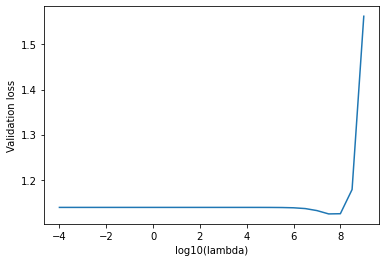

In [ ]:
x_train, y_train = get_inputs_labels_from_assays_logistic_cuda(train_assays)
x_val, y_val = get_inputs_labels_from_assays_logistic_cuda(val_assays)
x_test, y_test = get_inputs_labels_from_assays_logistic_cuda(test_assays)

lambdas = 10 ** np.arange(-4, 10, step = 0.5)
val_nll = np.zeros_like(lambdas)

lr = 0.0000000005
it = 100

for i,lamb in enumerate(lambdas): # try different settings of lambda
    print("curr lamb:", lamb)
    beta,_ = fit_logistic_reg( x_train, y_train, l2_lambda = lamb, learning_rate = lr, iterations = it)
    pred_val = torch.sigmoid(x_val @ beta) # make predictions on the validation set
    val_nll[i] = - torch.mean( y_val * torch.log(pred_val) + (1.-y_val) * torch.log(1.-pred_val) ).item() # item() gets the scalar value

plt.plot(np.log10(lambdas), val_nll)
plt.xlabel("log10(lambda)")
plt.ylabel("Validation loss")

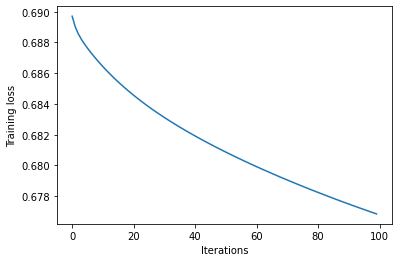

In [ ]:
optimal_lamb = lambdas[np.nanargmin(val_nll)]
beta_logr, losses = fit_logistic_reg(x_train, 
                                    y_train, 
                                    l2_lambda = optimal_lamb,
                                    learning_rate = 0.00000000005, iterations = it)

_ = plt.plot(losses)
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Training loss")

# ROC - AUC

##Logistic

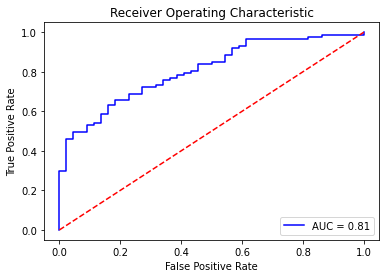

In [ ]:
#LOGISTIC
import sklearn.metrics as metrics

val_pred = torch.sigmoid(x_test @ beta_logr)
fpr, tpr, _ = metrics.roc_curve(y_test.cpu().numpy(), val_pred.cpu().numpy())
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

0.9009478746492205


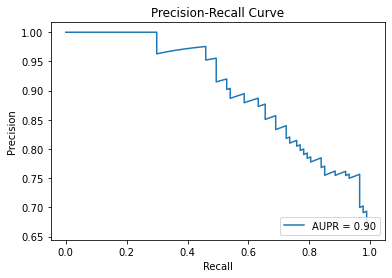

In [ ]:
precision, recall, thresh = metrics.precision_recall_curve(y_test.cpu().numpy(), val_pred.cpu().numpy())
auc_precision_recall = metrics.auc(recall, precision)
print(auc_precision_recall)

plt.plot(recall, precision, label = 'AUPR = %0.2f' % auc_precision_recall)

plt.title('Precision-Recall Curve')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show()

##Neural Network

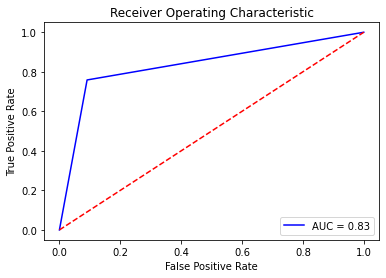

In [ ]:
# NEURAL NETWORK

import sklearn.metrics as metrics
import numpy as np

y_list = list()
pred_list = list()

model.eval()

with torch.no_grad():
    for x, y in dataloaders['test']:
        x = x.to(device=device)
        y = y.to(device=device)

        scores = model(x)
        _, predictions = scores.max(1)
        y_list.append(y[0].item())
        pred_list.append(predictions[0].item())


fpr, tpr, _ = metrics.roc_curve(np.array(y_list), np.array(pred_list))
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

0.9308915880118829


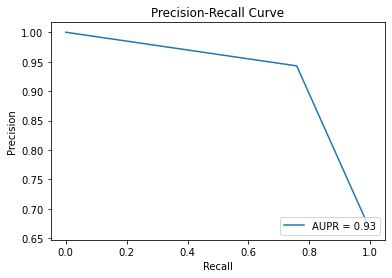

In [ ]:
precision, recall, thresh = metrics.precision_recall_curve(np.array(y_list), np.array(pred_list))
auc_precision_recall = metrics.auc(recall, precision)
print(auc_precision_recall)

plt.plot(recall, precision, label = 'AUPR = %0.2f' % auc_precision_recall)

plt.title('Precision-Recall Curve')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show()